# Implementing Firing in LIF Neurons

So far we have a neuron model that represents potential over time. However, we haven't implemented a crucial part of the neuron: **firing**! So let's go from a LI neuron to a LI**F** neuron. From [last time](./04%20-%20First%20Order%20LI.ipynb), we have:

In [ ]:
class FirstOrderLI: # First Order Leaky Integrate
    def __init__(self, tau_rc=0.2, v_init=0): # Default values for tau_rc and v_init
        self.tau_rc = tau_rc # Set instance variables
        self.v      = v_init

    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc



LIF neurons have two additional parameters:

- A threshold potential, $v_{th}$ where if the neuron's potential reaches this threshold, it will fire
- A refractory period, $\tau_{ref}$---after our neuron fires, this specifies how long until it will "accept" input again.

We are going to represent firing as the neuron's "output". By default, the output will be `0`. If a neuron is firing, its output will be `1/T_step` (dividing by `T_step` ensures that our neuron releases the same amount of energy regardless of how we tune our simulation's time step length).

We will thus add some additional instance variables to represent neuron parameters:
- `self.v_th` to represent the firing threshold, $v_{th}$. Default: `1`
- `self.tau_ref` to represent the refractory period, $\tau_{ref}$. Default: `0.002`

We also need to track two more instance variables:
- `self.output` to represent the output (`0` if not firing, `1/T_step` if firing at the current step)
- `self.refractory_time` to represent how much time we have left until our neuron can accept input.

In [1]:
class FirstOrderLIF:
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1): # ADDED: tau_ref and v_th
        self.tau_rc  = tau_rc
        self.v       = v_init

        # vvv ADDED vvv
        self.v_th    = v_th
        self.tau_ref = tau_ref

        self.output          = 0
        self.refractory_time = 0
        # ^^^ ADDED ^^^


    def step(self, I, t_step):
        self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc

Then, we need to modify the `step(I, t_step)` function to add firing. First, after the voltage is updated, we need to check if it is greater than the threshold. If it is, we fire (set `self.output` to `1/t_step`) and reset the voltage (set `self.v` to `0`):

```python
if self.v >= self.v_th:      # Voltage is above the threshold
    self.output = 1 / t_step # Fire
    self.v = 0               # Reset potential
else:
    self.output = 0          # Don't fire
```

But we don't just want to set `self.v` to `0`. We want it to **stay** at `0` for $\tau_{ref}$ (stored in the instance variable `self.tau_ref`) seconds. We use `self.refractory_time` to track how much time we have left until the neuron accepts input again. So let's modify the above code to set the refractory time remaining if the neuron fires:

```python
if self.v >= self.v_th:      # Voltage is above the threshold
    # vvv ADDED vvv
    self.refractory_time = self.tau_ref
    # ^^^ ADDED ^^^

    self.output = 1 / t_step # Fire
    self.v = 0               # Reset potential
else:
    self.output = 0          # Don't fire
```

We also want to update `self.refractory_time` every time we take a step:
```python
def step(self, I, t_step):
    self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time
    # ...
```

But we also need to check if we are in a refractory period before we update the voltage, so we need to wrap our update to `self.v` inside a conditional:

```python
def step(self, I, t_step):
    self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

    if self.refractory_time < 0: # If we aren't in our refractory period, update the voltage
        self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc
    
    # ...
```

Overall, this gives us:

In [3]:
class FirstOrderLIF: # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1):
        self.tau_rc  = tau_rc  # Potential decay time constant
        self.v       = v_init  # Potential value
        self.v_th    = v_th    # Firing threshold
        self.tau_ref = tau_ref # Refractory period time constant

        self.output          = 0 # Current output value
        self.refractory_time = 0 # Current refractory period time (how long until the neuron can fire again)
    
    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        if self.refractory_time < 0: # If the neuron is not in its refractory period
            self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc # Integrate the input current
        
        if self.v > self.v_th: # If the potential is above the threshold
            self.refractory_time = self.tau_ref # Enter the refractory period
            self.output = 1 / t_step            # Emit a spike
            self.v = 0                          # Reset the potential
        else: # If the potential is below the threshold
            self.output = 0 # Do not fire
        
        return self.output

Then, if we plot the output of our neuron, we should see it spike when the voltage reaches the threshold, and then be silent for the refractory period.

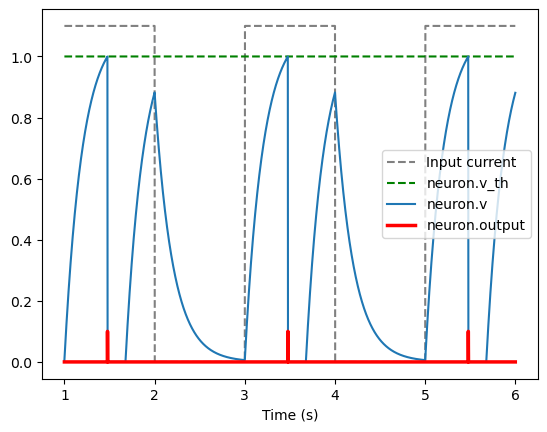

In [17]:

import numpy as np
import matplotlib.pyplot as plt

duration = 6  # Duration of the simulation
T_step = 0.001 # Time step size
times = np.arange(1, duration, T_step) # Create a range of time values

neuron = FirstOrderLIF(tau_ref = 0.2) # Create a new LIF neuron

def square_wave(t): # Our input current function will be a square wave
    return 0 if (t % 2) < 1 else 1.1

I_history = []
v_history = []
output_history = []
vth_history = []

for t in times: # Iterate over each time step
    I = square_wave(t)     # Get the input current at this time
    neuron.step(I, T_step) # Advance the neuron one time step

    I_history.append(I)    # Record the input current
    v_history.append(neuron.v) # Record the neuron's potential
    output_history.append(neuron.output * T_step / 10) # Record the neuron's output (scaled)
    vth_history.append(neuron.v_th) # Record the neuron's threshold


plt.figure() # Create a new figure
plt.plot(times, I_history, color="grey", linestyle="--")
plt.plot(times, vth_history, color="green", linestyle="--")
plt.plot(times, v_history)
plt.plot(times, output_history, color="red", linewidth=2.5)
plt.xlabel('Time (s)') # Label the x-axis
plt.legend(['Input current', 'neuron.v_th', 'neuron.v', 'neuron.output']) # Add a legend
plt.show() # Display the plot

Let's try this out in the code below. Try modifying the values of `v_th`, `tau_ref`, and `tau_rc` to see how they affect the firing behavior.


```{editor} python
:packages: matplotlib,numpy
:run_on_load: true
:max_height: 600px
import matplotlib.pyplot as plt
import numpy as np

# Simulation parameters
v_th    = 1.000 # Threshold voltage for neuron <-SLIDE(0.1 to 1 by 0.001)
tau_ref = 0.200 # Refractory period for neuron <-SLIDE(0 to 2 by 0.001)
tau_rc  = 0.10  # Time constant for neuron     <-SLIDE(0.01 to 1.2 by 0.01)

duration = 6   # Duration of the simulation
T_step = 0.001 # Time step size

class FirstOrderLIF: # # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1):
        self.tau_rc  = tau_rc  # Potential decay time constant
        self.v       = v_init  # Potential value
        self.v_th    = v_th    # Firing threshold
        self.tau_ref = tau_ref # Refractory period time constant

        self.output          = 0 # Current output value
        self.refractory_time = 0 # Current refractory period time (how long until the neuron can fire again)
    
    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        if self.refractory_time < 0: # If the neuron is not in its refractory period
            self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc # Integrate the input current
        
        if self.v > self.v_th: # If the potential is above the threshold
            self.refractory_time = self.tau_ref # Enter the refractory period
            self.output = 1 / t_step            # Emit a spike
            self.v = 0                          # Reset the potential
        else: # If the potential is below the threshold
            self.output = 0 # Do not fire
        
        return self.output

times = np.arange(1, duration, T_step) # Create a range of time values

neuron = FirstOrderLIF(tau_rc=tau_rc, tau_ref=tau_ref, v_th=v_th) # Create a new LIF neuron

def square_wave(t): # Our input current function will be a square wave
    return 0 if (t % 2) < 1 else 1.1

I_history = []
v_history = []
output_history = []
vth_history = []

for t in times: # Iterate over each time step
    I = square_wave(t)     # Get the input current at this time
    neuron.step(I, T_step) # Advance the neuron one time step

    I_history.append(I)    # Record the input current
    v_history.append(neuron.v) # Record the neuron's potential
    output_history.append(neuron.output * T_step / 10) # Record the neuron's output (scaled)
    vth_history.append(neuron.v_th) # Record the neuron's threshold


plt.figure() # Create a new figure
plt.plot(times, I_history, color="grey", linestyle="--")
plt.plot(times, vth_history, color="green", linestyle="--")
plt.plot(times, v_history)
plt.plot(times, output_history, color="red", linewidth=2.5)
plt.xlabel('Time (s)') # Label the x-axis
plt.legend(['Input current', 'neuron.v_th', 'neuron.v', 'neuron.output']) # Add a legend
plt.show() # Display the plot
```


## Summary

- We implemented LIF neurons with the following tuneable parameters:
  - $\tau_{rc}$, which specifies how quickly our potential decays
  - $v_{init}$, how much potential our neuron *starts* with
  - $\tau_{ref}$, which specifies the refractory period (after our neuron fires, how long until it accepts new inputs)
  - $v_{th}$, the threshold potential above which our neuron will fire.
- We simulate our neuron's behavior using a *discrete* time simulation, where we divide time into time steps of size $T_{step}$ (which should be small for better accuracy)
- The dynamics of our LIF neuron in discrete time are specified by the equations:
  - $v[0] = v_{init}$
  - $v[t] = v[t-1] (1 - \frac{T_{step}}{\tau_{rc}}) + \frac{T_{step}}{\tau_{rc}}I[t]$
- In our implementation, the `step()` method simulates a single time step for our LIF neuron


## References

- [The snnTorch overview of LIFs](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_2.html) is a very clear and helpful walkthrough through the logic of LIF neurons